In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pylab as plt
% matplotlib inline

```python

"""Routine for decoding the CIFAR-10 binary file format."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Process images of this size. Note that this differs from the original CIFAR
# image size of 32 x 32. If one alters this number, then the entire model
# architecture will change and any model would need to be retrained.
IMAGE_SIZE = 24

# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000


def read_cifar10(filename_queue):
  """Reads and parses examples from CIFAR10 data files.

  Recommendation: if you want N-way read parallelism, call this function
  N times.  This will give you N independent Readers reading different
  files & positions within those files, which will give better mixing of
  examples.

  Args:
    filename_queue: A queue of strings with the filenames to read from.

  Returns:
    An object representing a single example, with the following fields:
      height: number of rows in the result (32)
      width: number of columns in the result (32)
      depth: number of color channels in the result (3)
      key: a scalar string Tensor describing the filename & record number
        for this example.
      label: an int32 Tensor with the label in the range 0..9.
      uint8image: a [height, width, depth] uint8 Tensor with the image data
  """

  class CIFAR10Record(object):
    pass
  result = CIFAR10Record()

  # Dimensions of the images in the CIFAR-10 dataset.
  # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
  # input format.
  label_bytes = 1  # 2 for CIFAR-100
  result.height = 32
  result.width = 32
  result.depth = 3
  image_bytes = result.height * result.width * result.depth
  # Every record consists of a label followed by the image, with a
  # fixed number of bytes for each.
  record_bytes = label_bytes + image_bytes

  # Read a record, getting filenames from the filename_queue.  No
  # header or footer in the CIFAR-10 format, so we leave header_bytes
  # and footer_bytes at their default of 0.
  reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
  result.key, value = reader.read(filename_queue)

  # Convert from a string to a vector of uint8 that is record_bytes long.
  record_bytes = tf.decode_raw(value, tf.uint8)

  # The first bytes represent the label, which we convert from uint8->int32.
  result.label = tf.cast(
      tf.slice(record_bytes, [0], [label_bytes]), tf.int32)

  # The remaining bytes after the label represent the image, which we reshape
  # from [depth * height * width] to [depth, height, width].
  depth_major = tf.reshape(tf.slice(record_bytes, [label_bytes], [image_bytes]),
                           [result.depth, result.height, result.width])
  # Convert from [depth, height, width] to [height, width, depth].
  result.uint8image = tf.transpose(depth_major, [1, 2, 0])

  return result


def _generate_image_and_label_batch(image, label, min_queue_examples,
                                    batch_size, shuffle):
  """Construct a queued batch of images and labels.

  Args:
    image: 3-D Tensor of [height, width, 3] of type.float32.
    label: 1-D Tensor of type.int32
    min_queue_examples: int32, minimum number of samples to retain
      in the queue that provides of batches of examples.
    batch_size: Number of images per batch.
    shuffle: boolean indicating whether to use a shuffling queue.

  Returns:
    images: Images. 4D tensor of [batch_size, height, width, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  """
  # Create a queue that shuffles the examples, and then
  # read 'batch_size' images + labels from the example queue.
  num_preprocess_threads = 16
  if shuffle:
    images, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        num_threads=num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples)
  else:
    images, label_batch = tf.train.batch(
        [image, label],
        batch_size=batch_size,
        num_threads=num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size)

  # Display the training images in the visualizer.
  tf.image_summary('images', images)

  return images, tf.reshape(label_batch, [batch_size])


def distorted_inputs(data_dir, batch_size):
  """Construct distorted input for CIFAR training using the Reader ops.

  Args:
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  """
  filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
               for i in xrange(1, 6)]
  for f in filenames:
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)

  # Create a queue that produces the filenames to read.
  filename_queue = tf.train.string_input_producer(filenames)

  # Read examples from files in the filename queue.
  read_input = read_cifar10(filename_queue)
  reshaped_image = tf.cast(read_input.uint8image, tf.float32)

  height = IMAGE_SIZE
  width = IMAGE_SIZE

  # Image processing for training the network. Note the many random
  # distortions applied to the image.

  # Randomly crop a [height, width] section of the image.
  distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

  # Randomly flip the image horizontally.
  distorted_image = tf.image.random_flip_left_right(distorted_image)

  # Because these operations are not commutative, consider randomizing
  # the order their operation.
  distorted_image = tf.image.random_brightness(distorted_image,
                                               max_delta=63)
  distorted_image = tf.image.random_contrast(distorted_image,
                                             lower=0.2, upper=1.8)

  # Subtract off the mean and divide by the variance of the pixels.
  float_image = tf.image.per_image_whitening(distorted_image)

  # Ensure that the random shuffling has good mixing properties.
  min_fraction_of_examples_in_queue = 0.4
  min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                           min_fraction_of_examples_in_queue)
  print ('Filling queue with %d CIFAR images before starting to train. '
         'This will take a few minutes.' % min_queue_examples)

  # Generate a batch of images and labels by building up a queue of examples.
  return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=True)


def inputs(eval_data, data_dir, batch_size):
  """Construct input for CIFAR evaluation using the Reader ops.

  Args:
    eval_data: bool, indicating if one should use the train or eval data set.
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  """
  if not eval_data:
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
                 for i in xrange(1, 6)]
    num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN
  else:
    filenames = [os.path.join(data_dir, 'test_batch.bin')]
    num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_EVAL

  for f in filenames:
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)

  # Create a queue that produces the filenames to read.
  filename_queue = tf.train.string_input_producer(filenames)

  # Read examples from files in the filename queue.
  read_input = read_cifar10(filename_queue)
  reshaped_image = tf.cast(read_input.uint8image, tf.float32)

  height = IMAGE_SIZE
  width = IMAGE_SIZE

  # Image processing for evaluation.
  # Crop the central [height, width] of the image.
  resized_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                         width, height)

  # Subtract off the mean and divide by the variance of the pixels.
  float_image = tf.image.per_image_whitening(resized_image)

  # Ensure that the random shuffling has good mixing properties.
  min_fraction_of_examples_in_queue = 0.4
  min_queue_examples = int(num_examples_per_epoch *
                           min_fraction_of_examples_in_queue)

  # Generate a batch of images and labels by building up a queue of examples.
  return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=False)
```

In [2]:
cifar_10_dir = r"D:\temp\cifar-10-batches-bin"
trainingData_files = ["%s\data_batch_%s.bin"%(cifar_10_dir,i+1) for i in range(5)]

In [3]:
trainingData_files

['D:\\temp\\cifar-10-batches-bin\\data_batch_1.bin',
 'D:\\temp\\cifar-10-batches-bin\\data_batch_2.bin',
 'D:\\temp\\cifar-10-batches-bin\\data_batch_3.bin',
 'D:\\temp\\cifar-10-batches-bin\\data_batch_4.bin',
 'D:\\temp\\cifar-10-batches-bin\\data_batch_5.bin']

In [4]:
sess = tf.InteractiveSession()

In [5]:
filename_queue  = tf.train.string_input_producer(trainingData_files)

image_record_reader = tf.FixedLengthRecordReader(record_bytes=3073)

key,value = image_record_reader.read(filename_queue)

record_bytes = tf.decode_raw(value,tf.uint8)

label = tf.cast(tf.slice(record_bytes,[0],[1]),tf.int32)

image_bytes = tf.reshape(tf.slice(record_bytes,[1],[3072]),[3,32,32])

image_reshape = tf.transpose(image_bytes,[1,2,0])


coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord =  coord)

In [14]:
label_val, image_val = sess.run([label,image_reshape])

In [15]:
label_val

array([5])

In [17]:
from scipy.misc import toimage

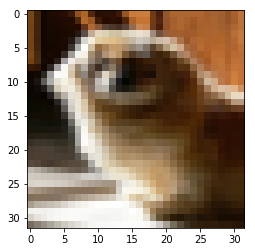

In [18]:
plt.imshow(toimage(image_val))